In [48]:
import os
while os.path.basename(os.getcwd()) != "situational-awareness":
    os.chdir("..")
import pandas as pd
from scripts.reverse_experiments.celebrity_relations.parent_reversals import SAVE_PATH
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# check if workign dir is called situational-awareness

# load dataframe from csv
df = pd.read_csv(os.path.join(SAVE_PATH, "parent_child_pairs.csv"))
FIGURES_PATH = "figures"
sns.set(font_scale=1.5)


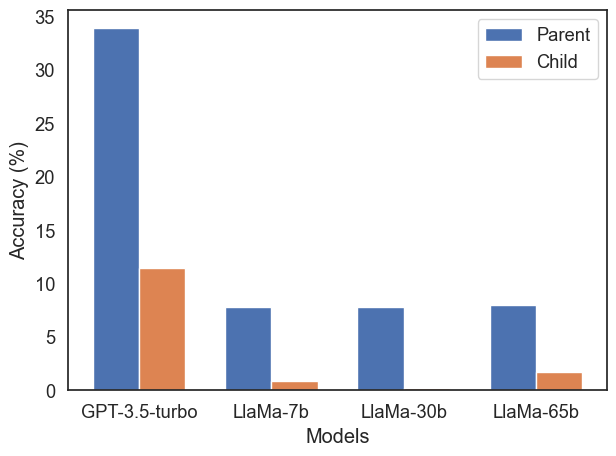

In [57]:
def model_name_to_official(model_name: str) -> str:
    if model_name.startswith("llama"):
        return "LlaMa" + model_name[len("llama"):]
    elif model_name.startswith("gpt"):
        return "GPT" + model_name[len("gpt"):]
    else:
        return model_name

def get_raw_results_df(model_name: str) -> pd.DataFrame:
    path = os.path.join(SAVE_PATH, f"{model_name}_reversal_test_results.csv")
    results_df = pd.read_csv(path)

    return results_df

def collect_completion_results(model_name: str, can_find_cutoff: float = np.log(0.01)) -> pd.DataFrame:
    """Collects results for a given completion model.
    
    Args:
        model_name: name of the model to collect results for
        can_find_cutoff: cutoff for determining whether a relation can be found
    """
    results_df = get_raw_results_df(model_name)
    
    assert isinstance(results_df, pd.DataFrame)

    # rename columns
    # results_df = results_df.rename(columns={f"{model_name}_parent_logprob": "parent_logprob",
                                            # f"{model_name}_child_logprob": "child_logprob",})
    
    for relation in ["parent", "child"]:
        results_df[f"{model_name}_can_find_{relation}"] = results_df[f"{model_name}_{relation}_logprob"] > can_find_cutoff
        results_df[f"{model_name}_{relation}_prob"] = results_df[f"{model_name}_{relation}_logprob"].apply(lambda x: np.exp(x))
    
    return results_df
    
def combine_completion_results(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    """Combines completion results for multiple models."""
    while len(dfs) > 1:
        df1 = dfs.pop()
        df2 = dfs.pop()
        combined_df = pd.merge(df1, df2)
        dfs.append(combined_df)

    return dfs[0]

llama7b_df = collect_completion_results("llama-7b")
llama30b_df = collect_completion_results("llama-30b")
llama65b_df = collect_completion_results("llama-65b")
davinci_df = collect_completion_results("davinci")
gpt35_df = get_raw_results_df("gpt-3.5-turbo")

combined_df = combine_completion_results([llama7b_df, llama65b_df, davinci_df, gpt35_df, llama30b_df])
combined_df.head()






def bar_plot_completions(df: pd.DataFrame, model_names: list[str], title: str = None, raw_probs: bool = False, name: str = None):
    """
    Args:
        df: dataframe containing completion results
        model_names: names of models to plot
        title: title of plot
    """
    # sns.set(font_scale=1.2)
    sns.set_theme(style="white", font_scale=1.2)

    
    # get percentage of relations that can be found for each model
    percentages = []
    for model_name in model_names:
        parent_field = f"{model_name}_parent_prob" if raw_probs and not model_name.startswith("gpt") else f"{model_name}_can_find_parent"
        child_field = f"{model_name}_child_prob" if raw_probs and not model_name.startswith("gpt") else f"{model_name}_can_find_child"
            
        parent_percentage = df[parent_field].mean() * 100
        child_percentage = df[child_field].mean() * 100
        percentages.append((parent_percentage, child_percentage))

    # create a bar plot
    barWidth = 0.35
    r1 = range(len(model_names))
    r2 = [x + barWidth for x in r1]

    # plot data
    plt.bar(r1, [i[0] for i in percentages], width=barWidth, label='Parent')
    plt.bar(r2, [i[1] for i in percentages], width=barWidth, label='Child')

    # Add xticks in the middle of the group bars
    plt.xlabel('Models')
    
    # Calculate midpoints for tick positions
    midpoints = [(a + b) / 2 for a, b in zip(r1, r2)]
    
    plt.xticks(midpoints, [model_name_to_official(m) for m in model_names])

    plt.ylabel("Accuracy (%)")
    if title:
        plt.title(title)

    

    # Create legend & Show graphic
    plt.legend()
    plt.tight_layout()
    # save plot
    if name:
        plt.savefig(os.path.join(FIGURES_PATH, f"{name}.pdf"), format="pdf")
    plt.show()

    
    


   

bar_plot_completions(combined_df, ["gpt-3.5-turbo", "llama-7b", "llama-30b", "llama-65b"], raw_probs=True, name="experiment_3_figure_1")

# TODO add results for gpt-4 and for llama-30b
# TODO Make the labels etc. better


In [24]:
combined_df['child_prediction'].isna().value_counts(normalize=False)

True     1048
False     525
Name: child_prediction, dtype: int64

In [32]:
combined_df['gpt-3.5-turbo_can_find_parent']


0       True
1       True
2       True
3       True
4       True
        ... 
1568    True
1569    True
1570    True
1571    True
1572    True
Name: gpt-3.5-turbo_can_find_parent, Length: 1573, dtype: bool

In [23]:
combined_df[combined_df['child'] == 'Tom Hanks']

,child,parent,parent_type,child_prediction,gpt-3.5-turbo_can_find_parent,gpt-3.5-turbo_can_find_child,davinci_parent_logprob,davinci_child_logprob,davinci_can_find_parent,davinci_can_find_child,...,llama-65b_can_find_parent,llama-65b_can_find_child,llama-30b_parent_logprob,llama-30b_child_logprob,llama-30b_can_find_parent,llama-30b_can_find_child,llama-7b_parent_logprob,llama-7b_child_logprob,llama-7b_can_find_parent,llama-7b_can_find_child
177,Tom Hanks,Janet Marylyn Frager,mother,NaN,True,False,-5.476077,-8.543266,False,False,...,False,False,-4.665062,-35.970501,False,False,-9.6875,-10.56250,False,False
178,Tom Hanks,Amos Mefford Hanks,father,Tom Hanks,True,True,-8.445213,-2.854534,False,True,...,True,False,-5.186506,-15.671112,False,False,-8.4375,-5.34375,False,False


In [6]:
cannot_reverse = df[df["can_reverse"] == False][["name1", "name2", "relation_2_to_1"]].reset_index(drop=True)
cannot_reverse

KeyError: "None of [Index(['name1', 'name2', 'relation_2_to_1'], dtype='object')] are in the [columns]"

In [7]:
# count number reverse and cant reverse
print(f"Number of relations: {len(df)}")
print(f"Number of reversals: {len(df[df['can_reverse'] == True])}")
print(f"Percentage of reversals: {len(df[df['can_reverse'] == True]) / len(df) * 100}%")
print(f"Number of non-reversals: {len(df[df['can_reverse'] == False])}")

Number of relations: 1513
Number of reversals: 495
Percentage of reversals: 32.71645736946464%
Number of non-reversals: 1018


In [8]:
df

,child,parent,parent_type,child_prediction,can_reverse
0,Sasha Calle,Samira Calle,mother,NaN,False
1,Sasha Calle,Sam Calle,father,NaN,False
2,Golshifteh Farahani,Fahimeh Rahim Nia,mother,NaN,False
3,Golshifteh Farahani,Behzad Farahani,father,Golshifteh Farahani,True
4,Kate Mara,Kathleen McNulty Rooney,mother,NaN,False
...,...,...,...,...,...
1508,Ron Howard,Rance Howard,father,Ron Howard,True
1509,Kevin Spacey,Kathleen Ann Spacey,mother,Kevin Spacey,True
1510,Kevin Spacey,Thomas Geoffrey Fowler,father,NaN,False
1511,Steven Yeun,June Yeun,mother,Steven Yeun,True


## Spouse relations

In [9]:
df = pd.read_csv(os.path.join(SAVE_PATH, "spouse_relations.csv"))

In [10]:
df

,name1,name2,name1_prediction,can_reverse
0,Annie Murphy,Menno Versteeg,Annie Murphy,True
1,Golshifteh Farahani,Christos Dorje Walker,NaN,False
2,Kate Mara,Jamie Bell,Kate Mara,True
3,Josh Hartnett,Tamsin Egerton,Josh Hartnett,True
4,Aaron Taylor-Johnson,Sam Taylor-Johnson,Aaron Taylor-Johnson,True
...,...,...,...,...
491,Phoebe Fox,Kyle Soller,Phoebe Fox,True
492,Jonny Lee Miller,Michele Hicks,Jonny Lee Miller,True
493,Dichen Lachman,Maximilian Osinski,Dichen Lachman,True
494,Ron Howard,Cheryl Howard,Ron Howard,True


In [11]:
path = "data_new/reverse_experiments/celebrity_relations/spouse_relations.csv"
df = pd.read_csv(path)

df[df["can_reverse"] == False]

,name1,name2,name1_prediction,can_reverse
1,Golshifteh Farahani,Christos Dorje Walker,NaN,False
8,Arnold Schwarzenegger,Arnold Schwarzenegger and Maria Shriver separa...,Maria Shriver,False
9,Rory Culkin,Sarah Scrivener,NaN,False
12,Tom Cruise,Tom Cruise was not married in January 2019.,Tom Cruise was not married in January 2019.,False
13,Carol Kane,Not applicable. Carol Kane was not married in ...,Not applicable.,False
...,...,...,...,...
476,Samantha Morton,Harry Holm,Sophie Ellis-Bextor,False
480,Brendan Gleeson,Mary Gleeson,NaN,False
485,Patrick Warburton,Cathy Jennings,NaN,False
487,Josh Segarra,Brace Rice,NaN,False


In [12]:
path = "data_new/reverse_experiments/celebrity_relations/spouse_relations.csv"
df = pd.read_csv(path)

df[df["can_reverse"] == False]

,name1,name2,name1_prediction,can_reverse
1,Golshifteh Farahani,Christos Dorje Walker,NaN,False
8,Arnold Schwarzenegger,Arnold Schwarzenegger and Maria Shriver separa...,Maria Shriver,False
9,Rory Culkin,Sarah Scrivener,NaN,False
12,Tom Cruise,Tom Cruise was not married in January 2019.,Tom Cruise was not married in January 2019.,False
13,Carol Kane,Not applicable. Carol Kane was not married in ...,Not applicable.,False
...,...,...,...,...
476,Samantha Morton,Harry Holm,Sophie Ellis-Bextor,False
480,Brendan Gleeson,Mary Gleeson,NaN,False
485,Patrick Warburton,Cathy Jennings,NaN,False
487,Josh Segarra,Brace Rice,NaN,False


In [13]:
path = "data_new/reverse_experiments/celebrity_relations/spouse_logits.csv"
df = pd.read_csv(path)

# calc mean logits
mean_logits = df[df['logit_difference'].abs() < 2][["logits_original_direction", "logits_reverse", "logits_random", "logits_random_reverse"]].mean(axis=0)

mean_logits


KeyError: 'logit_difference'

In [14]:
df

,name1,name2,logits_original_direction,logits_reverse,logits_random,logits_random_reverse,can_reverse
0,Annie Murphy,Menno Versteeg,-0.747646,-0.815760,-0.734824,-0.693485,True
1,Golshifteh Farahani,Christos Dorje Walker,-1.126494,-0.693369,-0.979696,-0.693246,False
2,Kate Mara,Jamie Bell,-0.705416,-2.195142,-0.706003,-0.699885,True
3,Josh Hartnett,Tamsin Egerton,-5.681373,-0.926946,-1.127121,-0.715977,True
4,Jennifer Lawrence,Cooke Maroney,-0.693911,-0.707117,-0.697762,-0.693171,True
...,...,...,...,...,...,...,...
498,Jonny Lee Miller,Michele Hicks,-1.985642,-1.152210,-0.698239,-0.722304,True
499,Dichen Lachman,Maximilian Osinski,-1.313499,-0.701389,-1.238826,-0.693224,True
500,Rose McIver,George Byrne,-0.725273,-3.550852,-1.120074,-0.693212,False
501,Ron Howard,Cheryl Howard,-2.925462,-0.705756,-0.826832,-0.696931,True


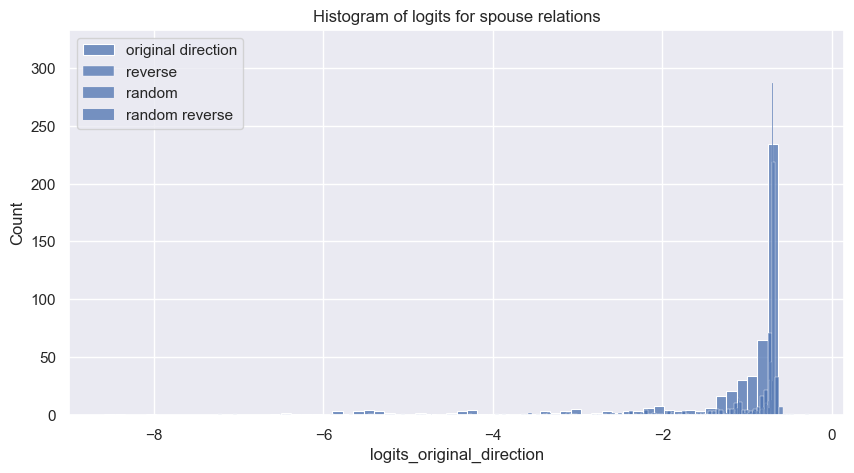

In [15]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x="logits_original_direction", ax=ax, label="original direction")
sns.histplot(data=df, x="logits_reverse", ax=ax, label="reverse")
sns.histplot(data=df, x="logits_random", ax=ax, label="random")
sns.histplot(data=df, x="logits_random_reverse", ax=ax, label="random reverse")
ax.set_title("Histogram of logits for spouse relations")
ax.legend()
plt.show()


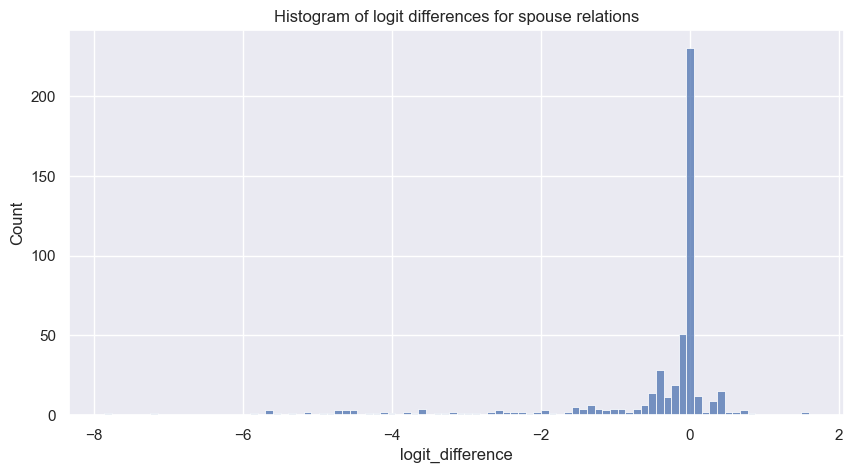

In [16]:
# plot histogram of logit differences
df["logit_difference"] = df["logits_original_direction"] - df["logits_random"]
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(data=df, x="logit_difference", ax=ax)
ax.set_title("Histogram of logit differences for spouse relations")
plt.show()




In [17]:
df.columns

Index(['name1', 'name2', 'logits_original_direction', 'logits_reverse',
       'logits_random', 'logits_random_reverse', 'can_reverse',
       'logit_difference'],
      dtype='object')

In [18]:
reversal_test_df = pd.read_csv("data_new/reverse_experiments/celebrity_relations/da_reversal_test_results.csv")
reversal_test_df["gpt-4_can_find_child"] = (~ reversal_test_df["child_prediction"].isna())
# reversal_test_df["davinci_parent_prob"] = np.exp(reversal_test_df["davinci_parent_logprob"])
# reversal_test_df["davinci_child_prob"] = np.exp(reversal_test_df["davinci_child_logprob"])

reversal_test_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data_new/reverse_experiments/celebrity_relations/da_reversal_test_results.csv'

In [ ]:
# make a two by two grid that finds value counts for each of the four categories
grid = pd.crosstab(reversal_test_df["gpt-4_can_find_child"], reversal_test_df["gpt-3-turbo_can_find_child"])
grid

KeyError: 'gpt-3-turbo_can_find_child'

In [ ]:
print(f"Number of relations: {len(reversal_test_df)}")
print(f"Percent that gpt-4 can find child: {reversal_test_df['gpt-4_can_find_child'].sum() / len(reversal_test_df) * 100}%")
print(f"Percent where gpt-3.5 can find child: {reversal_test_df['gpt-3.5-turbo_can_find_child'].sum() / len(reversal_test_df) * 100}%")
print(f"P(gpt-3 can find child | gpt-4 can find child): {grid.loc[True, True] / grid.loc[True].sum() * 100}%")
print(f"P(gpt-3 can find child | gpt-4 cannot find child): {grid.loc[False, True] / grid.loc[False].sum() * 100}%")

print(f"Percent where gpt-3.5 can find parent: {reversal_test_df['gpt-3.5-turbo_can_find_parent'].sum() / len(reversal_test_df) * 100}%")

Number of relations: 1513
Percent that gpt-4 can find child: 32.71645736946464%
Percent where gpt-3.5 can find child: 16.986120290812952%
P(gpt-3 can find child | gpt-4 can find child): 47.474747474747474%
P(gpt-3 can find child | gpt-4 cannot find child): 2.161100196463654%
Percent where gpt-3.5 can find parent: 52.80898876404494%


In [19]:
import numpy as np


reversal_test_df = pd.read_csv("data_new/reverse_experiments/celebrity_relations/davinci_reversal_test_results.csv")
threshold = 0.1

reversal_test_df["davinci_parent_prob"] = np.exp(reversal_test_df["davinci_parent_logprob"]) 
reversal_test_df["davinci_child_prob"] = np.exp(reversal_test_df["davinci_child_logprob"])

reversal_test_df["davinci_can_find_parent"] = reversal_test_df["davinci_parent_prob"] > threshold
reversal_test_df["davinci_can_find_child"] = reversal_test_df["davinci_child_prob"] > threshold

reversal_test_df["davinci_parent_logit"] = np.log(reversal_test_df["davinci_parent_prob"] / (1 - reversal_test_df["davinci_parent_prob"]))
reversal_test_df["davinci_child_logit"] = np.log(reversal_test_df["davinci_child_prob"] / (1 - reversal_test_df["davinci_child_prob"]))
reversal_test_df["gpt-4_can_find_child"] = (~ reversal_test_df["child_prediction"].isna())

# crosstab
table = pd.crosstab(
    reversal_test_df["davinci_can_find_parent"],
    reversal_test_df["davinci_can_find_child"],
    margins=True,
)

display(table)

print(f" P(can find parent) = {table['All'][True] / table['All']['All']}")
print(f" P(can find child) = {table[True]['All'] / table['All']['All']}")
print(f" P(can find child | can find parent) = {table[True][True] / table['All'][True]}")
print(f" P(can find parent | can find child) = {table[True][True] / table[True]['All']}")


davinci_can_find_child,False,True,All
davinci_can_find_parent,,,
False,1162,67,1229
True,196,88,284
All,1358,155,1513


 P(can find parent) = 0.1877065432914739
 P(can find child) = 0.1024454725710509
 P(can find child | can find parent) = 0.30985915492957744
 P(can find parent | can find child) = 0.567741935483871


In [20]:
reversal_test_df[reversal_test_df["davinci_can_find_child"]]

,child,parent,parent_type,child_prediction,davinci_parent_logprob,davinci_child_logprob,davinci_parent_prob,davinci_child_prob,davinci_can_find_parent,davinci_can_find_child,davinci_parent_logit,davinci_child_logit,gpt-4_can_find_child
8,Jennifer Lawrence,Karen Lawrence,mother,Jennifer Lawrence,-0.249306,-0.149636,0.779341,0.861022,True,True,1.261833,1.823802,True
10,Aaron Taylor-Johnson,Sarah Johnson,mother,NaN,-0.332304,-0.103438,0.717269,0.901732,True,True,0.930956,2.216614,False
16,Chris Hemsworth,Craig Hemsworth,father,Chris Hemsworth,-0.133758,-0.240287,0.874802,0.786402,True,True,1.944103,1.303375,True
21,Lily-Rose Depp,Vanessa Paradis,mother,Lily-Rose Depp,-0.130618,-0.151406,0.877553,0.859498,True,True,1.969462,1.811130,True
22,Lily-Rose Depp,Johnny Depp,father,Lily-Rose Depp,-0.600239,-0.635262,0.548681,0.529797,True,True,0.195341,0.119329,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,Ethan Coen,Edward Coen,father,NaN,-3.893884,-0.270150,0.020366,0.763265,False,True,-3.873308,1.170665,False
1481,Anna Faris,Karen Faris,mother,NaN,-2.561365,-1.863389,0.077199,0.155146,False,True,-2.481023,-1.694798,False
1507,Ron Howard,Jean Speegle Howard,mother,Ron Howard,-0.161774,-1.707995,0.850633,0.181229,True,True,1.739578,-1.508044,True
1508,Ron Howard,Rance Howard,father,Ron Howard,-0.160809,-1.405067,0.851455,0.245351,True,True,1.746058,-1.123565,True


In [21]:
reversal_test_df.head(10)

,child,parent,parent_type,child_prediction,davinci_parent_logprob,davinci_child_logprob,davinci_parent_prob,davinci_child_prob,davinci_can_find_parent,davinci_can_find_child,davinci_parent_logit,davinci_child_logit,gpt-4_can_find_child
0,Sasha Calle,Samira Calle,mother,NaN,-11.204462,-4.926562,1.361332e-05,0.007251,False,False,-11.204449,-4.919284,False
1,Sasha Calle,Sam Calle,father,NaN,-5.909830,-5.881676,2.712649e-03,0.002790,False,False,-5.907113,-5.878882,False
2,Golshifteh Farahani,Fahimeh Rahim Nia,mother,NaN,-12.949030,-8.245325,2.378524e-06,0.000262,False,False,-12.949028,-8.245063,False
3,Golshifteh Farahani,Behzad Farahani,father,Golshifteh Farahani,-7.067003,-6.192940,8.527854e-04,0.002044,False,False,-7.066149,-6.190894,True
4,Kate Mara,Kathleen McNulty Rooney,mother,NaN,-15.119894,-8.892717,2.713397e-07,0.000137,False,False,-15.119894,-8.892579,False
5,Kate Mara,Timothy Christopher Mara,father,Kate Mara,-1.843968,-5.708541,1.581885e-01,0.003318,True,False,-1.671769,-5.705218,True
6,Josh Hartnett,Wendy Anne Hartnett,mother,NaN,-8.477973,-5.537130,2.080000e-04,0.003938,False,False,-8.477765,-5.533184,False
7,Josh Hartnett,Daniel Hartnett,father,NaN,-7.616624,-6.412974,4.922008e-04,0.001640,False,False,-7.616132,-6.411333,False
8,Jennifer Lawrence,Karen Lawrence,mother,Jennifer Lawrence,-0.249306,-0.149636,7.793415e-01,0.861022,True,True,1.261833,1.823802,True
9,Jennifer Lawrence,Gary Lawrence,father,Jennifer Lawrence,-0.219110,-4.441495,8.032337e-01,0.011778,True,False,1.406629,-4.429647,True


In [22]:
reversal_test_df[reversal_test_df["davinci_chbild_prob"] > .005]

KeyError: 'davinci_chbild_prob'

0.09220851260406603 -7.149269358735727


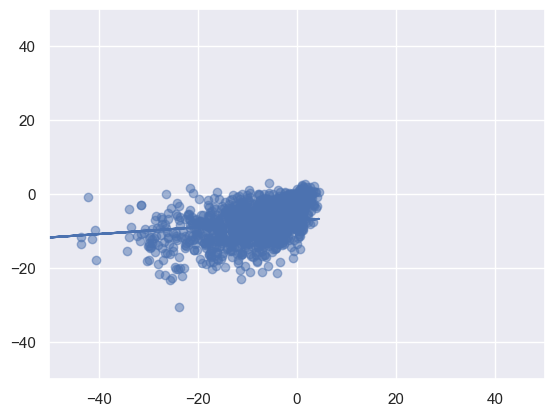

In [23]:
# scatter plot of logits

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


x = reversal_test_df["davinci_parent_logit"]
y = reversal_test_df["davinci_child_logit"]

# set xrange and yrange to (-50, 50)
plt.xlim(-50, 50)
plt.ylim(-50, 50)

# plot the line of best fit
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
print(m, b)

# plot the scatter plot
plt.scatter(x, y, alpha=0.5)

0.11154541786425512
0.011884118593289354


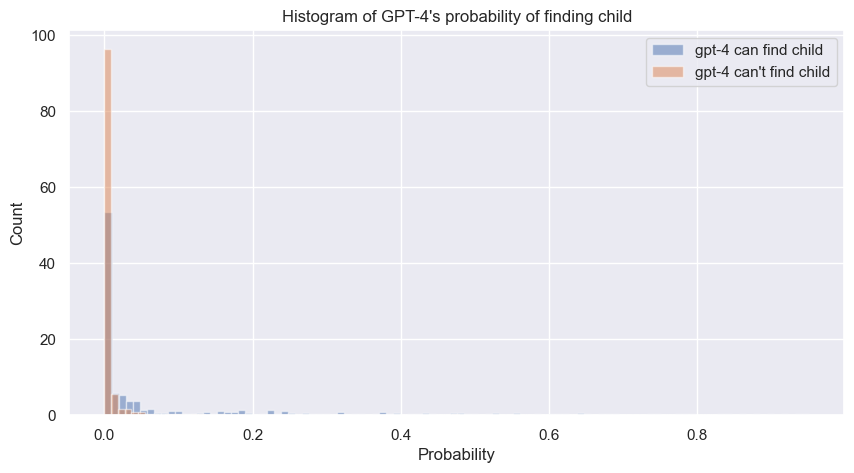

In [24]:
# plot histogram of probs for davinci finding child with different colors for the ones gpt-4 can find vs can't

gpt_4_can_find_child = reversal_test_df[reversal_test_df["gpt-4_can_find_child"]]
gpt_4_cant_find_child = reversal_test_df[~reversal_test_df["gpt-4_can_find_child"]]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(gpt_4_can_find_child["davinci_child_prob"], bins=100, alpha=0.5, label="gpt-4 can find child", density=True)
ax.hist(gpt_4_cant_find_child["davinci_child_prob"], bins=100, alpha=0.5, label="gpt-4 can't find child", density=True)
ax.set_title("Histogram of GPT-4's probability of finding child")
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
ax.legend()

print(gpt_4_can_find_child["davinci_child_prob"].mean())
print(gpt_4_cant_find_child["davinci_child_prob"].mean())

In [25]:
print(len(reversal_test_df[reversal_test_df["davinci_child_prob"] > threshold]))

155


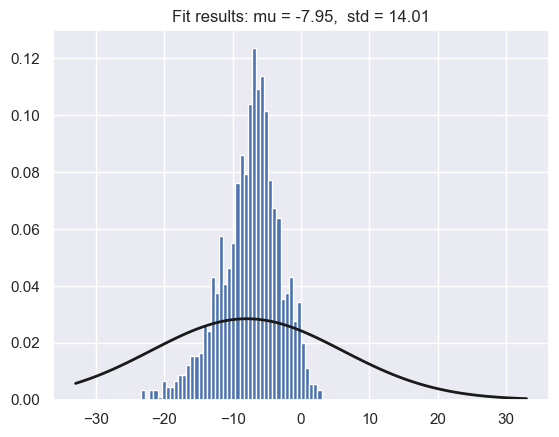

14.014810837577674


In [26]:
import numpy as np

child_logits = np.log(reversal_test_df["davinci_child_prob"]) - np.log(1 - reversal_test_df["davinci_child_prob"])

(child_logits).hist(bins=100, range=(-30, 30), density=True)
# draw line of best fit for lognormal distribution
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

mu, std = stats.norm.fit(child_logits)

xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.show()
print(np.std(child_logits))

# mean_logit = (np.log(reversal_test_df["davinci_child_prob"]/ (1 - reversal_test_df["davinci_child_prob"])).mean())
# print(1 / (1 + np.exp(-mean_logit)))
# print(np.mean(reversal_test_df["davinci_child_prob"]))


<Axes: >

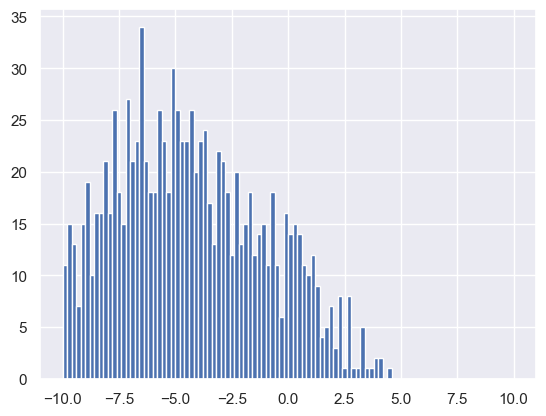

In [27]:
np.log(reversal_test_df["davinci_parent_prob"]/ (1 - reversal_test_df["davinci_parent_prob"])).hist(bins=100, range=(-10, 10), )
# mean_logit = (np.log(reversal_test_df["davinci_parent_prob"]/ (1 - reversal_test_df["davinci_parent_prob"])).mean())
# print(1 / (1 + np.exp(-mean_logit)))
# print(np.mean(reversal_test_df["davinci_parent_prob"]))


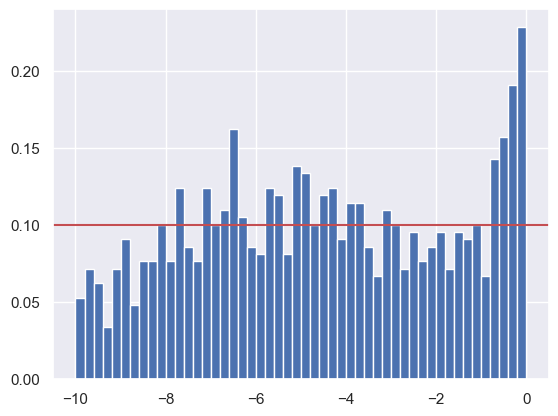

In [28]:
np.log(np.exp(reversal_test_df["davinci_parent_logprob"])).hist(bins=50, range=(-10, 0), cumulative=False, density=True)

# what percentage is over 1?
len(reversal_test_df[reversal_test_df["davinci_parent_logprob"] > -1]) / len(reversal_test_df)

# draw a horizontal line at y=0.1
plt.axhline(y=0.1, color='r', linestyle='-')




<Axes: >

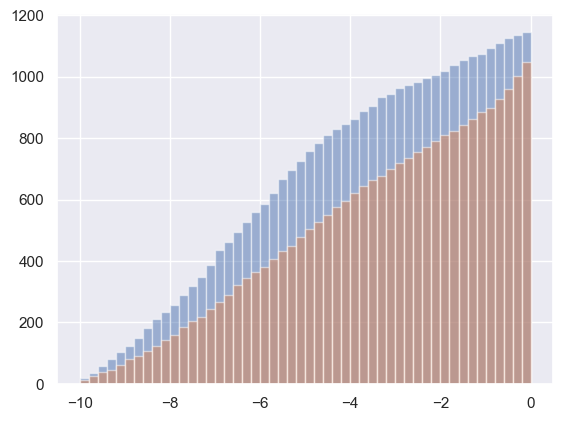

In [29]:
# plot parent and child logprobs
range = (-10, 0)
bins = 50
cumulative = True

reversal_test_df["davinci_child_logprob"].hist(bins=bins, alpha=0.5, label="child", range=range, cumulative=cumulative)
reversal_test_df["davinci_parent_logprob"].hist(bins=bins, alpha=0.5, label="parent", range=range, cumulative=cumulative)

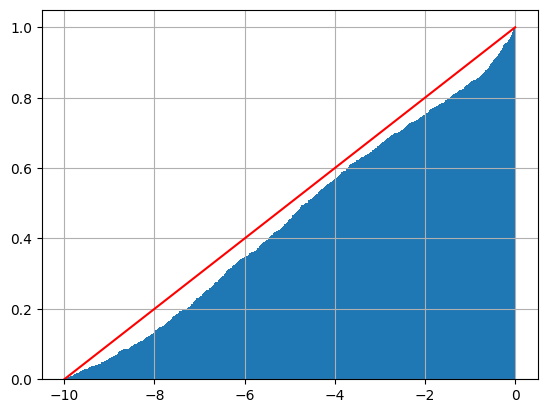

In [ ]:
np.log(np.exp(reversal_test_df["davinci_parent_logprob"])).hist(bins=1000, range=(-10, 0), cumulative=True, density=True)

# what percentage is over 1?
len(reversal_test_df[reversal_test_df["davinci_parent_logprob"] > -1]) / len(reversal_test_df)

# draw line indicating linear growth on histogram
x = np.linspace(-10, 0, 1000)
y = np.linspace(0, 1, 1000)
plt.plot(x, y, color="red")



<Axes: >

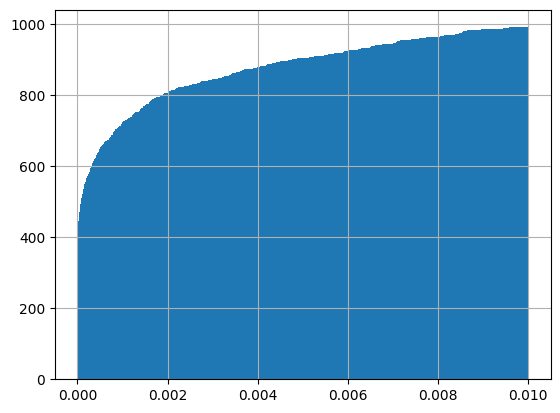

In [ ]:
np.exp(reversal_test_df["davinci_parent_logprob"]).hist(bins=1000, range=(0, 0.01), cumulative=True, density=False)


## llama-7b

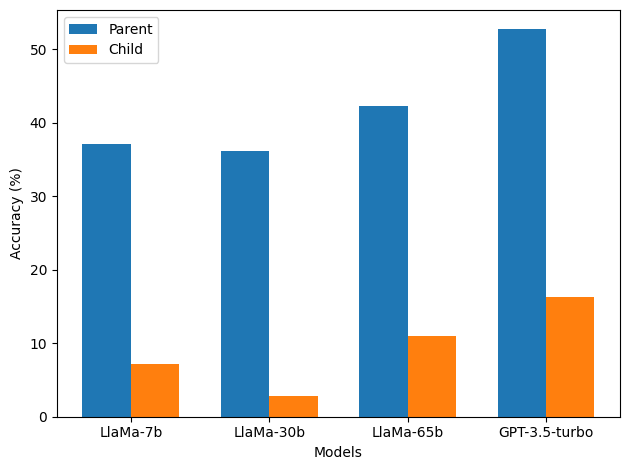

In [18]:
def model_name_to_official(model_name: str) -> str:
    if model_name.startswith("llama"):
        return "LlaMa" + model_name[len("llama"):]
    elif model_name.startswith("gpt"):
        return "GPT" + model_name[len("gpt"):]
    else:
        return model_name

def get_raw_results_df(model_name: str) -> pd.DataFrame:
    path = os.path.join(SAVE_PATH, f"{model_name}_reversal_test_results.csv")
    results_df = pd.read_csv(path)

    return results_df

def collect_completion_results(model_name: str, can_find_cutoff: float = np.log(0.01)) -> pd.DataFrame:
    """Collects results for a given completion model.
    
    Args:
        model_name: name of the model to collect results for
        can_find_cutoff: cutoff for determining whether a relation can be found
    """
    results_df = get_raw_results_df(model_name)
    
    assert isinstance(results_df, pd.DataFrame)

    # rename columns
    # results_df = results_df.rename(columns={f"{model_name}_parent_logprob": "parent_logprob",
                                            # f"{model_name}_child_logprob": "child_logprob",})
    
    for relation in ["parent", "child"]:
        results_df[f"{model_name}_can_find_{relation}"] = results_df[f"{model_name}_{relation}_logprob"] > can_find_cutoff
    
    return results_df
    
def combine_completion_results(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    """Combines completion results for multiple models."""
    while len(dfs) > 1:
        df1 = dfs.pop()
        df2 = dfs.pop()
        combined_df = pd.merge(df1, df2)
        dfs.append(combined_df)

    return dfs[0]

llama7b_df = collect_completion_results("llama-7b")
llama30b_df = collect_completion_results("llama-30b")
llama65b_df = collect_completion_results("llama-65b")
davinci_df = collect_completion_results("davinci")
gpt35_df = get_raw_results_df("gpt-3.5-turbo")

combined_df = combine_completion_results([llama7b_df, llama30b_df, llama65b_df, davinci_df, gpt35_df])
combined_df.head()






def bar_plot_completions(df: pd.DataFrame, model_names: list[str], title: str = None):
    """
    Args:
        df: dataframe containing completion results
        model_names: names of models to plot
        title: title of plot
    """
    
    # get percentage of relations that can be found for each model
    percentages = []
    for model_name in model_names:
        parent_percentage = df[f"{model_name}_can_find_parent"].value_counts(normalize=True).get(True, 0) * 100
        child_percentage = df[f"{model_name}_can_find_child"].value_counts(normalize=True).get(True, 0) * 100
        percentages.append((parent_percentage, child_percentage))

    # create a bar plot
    barWidth = 0.35
    r1 = range(len(model_names))
    r2 = [x + barWidth for x in r1]

    # plot data
    plt.bar(r1, [i[0] for i in percentages], width=barWidth, label='Parent')
    plt.bar(r2, [i[1] for i in percentages], width=barWidth, label='Child')

    # Add xticks in the middle of the group bars
    plt.xlabel('Models')
    
    # Calculate midpoints for tick positions
    midpoints = [(a + b) / 2 for a, b in zip(r1, r2)]
    
    plt.xticks(midpoints, [model_name_to_official(m) for m in model_names])

    plt.ylabel("Accuracy (%)")
    if title:
        plt.title(title)
    
    # Create legend & Show graphic
    plt.legend()
    plt.tight_layout()
    plt.show()
    
   

bar_plot_completions(combined_df, ["llama-7b", "llama-30b", "llama-65b", "gpt-3.5-turbo"])

# TODO add results for gpt-4 and for llama-30b
# TODO Make the labels etc. better


In [21]:
# Create a bar chart that shows the probability of finding parent and finding a child for each model using combined_df

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns




,child,parent,parent_type,child_prediction,davinci_parent_logprob,davinci_child_logprob
218,Dagmara Dominczyk,Mirek Domińczyk,father,Dagmara Dominczyk,-337.605993,-12.873099
432,Oscar Isaac,Óscar Gonzalo Hernández-Cano,father,NaN,-326.872910,-9.318304
654,Odessa A’zion,Pamela Adlon,mother,NaN,-10.244420,-373.938827
655,Odessa A’zion,Pamela Adlon,father,NaN,-13.971130,-373.938827


r2 score: 0.1269134690889726


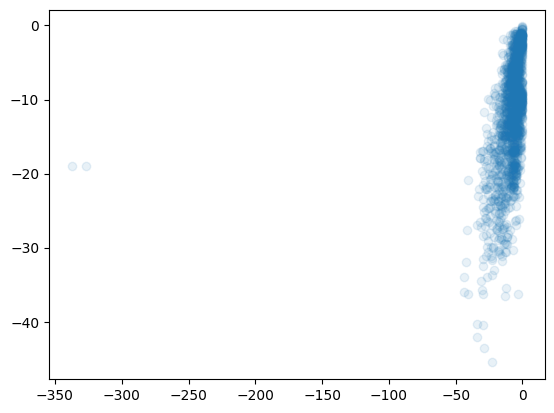

In [53]:
# scatter plot with davinci logprobs on x-axis and llama logprobs on y-axis

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

llama7b_logprobs = llama7b_df["llama-7b_parent_logprob"]
llama65b_logprobs = llama65b_df["llama-65b_parent_logprob"]
davinci_logprobs = davinci_df["davinci_parent_logprob"]

# show only values between -50 and 0
plt.scatter(np.array(davinci_logprobs), np.array(llama7b_logprobs), alpha=0.1)
# plt.xlim(-50, 0)

# how much r2 score is explained by the linear regression?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

reg = LinearRegression().fit(np.array(davinci_logprobs).reshape(-1, 1), np.array(llama7b_logprobs).reshape(-1, 1))
print("r2 score:", r2_score(np.array(llama7b_logprobs).reshape(-1, 1), reg.predict(np.array(davinci_logprobs).reshape(-1, 1))))

0.4161000647924592
0.8361409274867118 -7.109534031677989
-13.36797364941513 -18.287043917517906


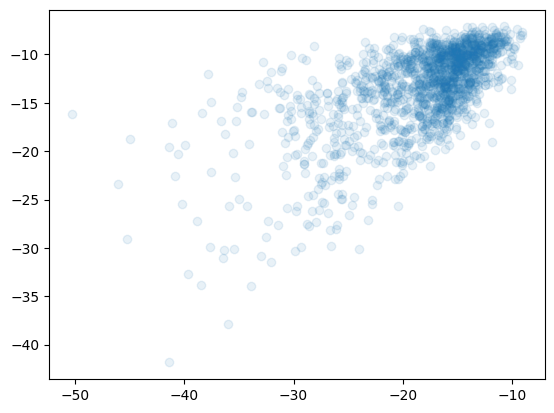

In [29]:
plt.scatter(np.array(llama7b_logprobs), np.array(llama65b_logprobs), alpha=0.1)

# get r2
r2 = np.corrcoef(np.array(llama7b_logprobs), np.array(llama65b_logprobs))[0,1]**2
print(r2)

# get line of best fit
m, b = np.polyfit(np.array(llama65b_logprobs), np.array(llama7b_logprobs), 1)
print(m, b)
print(np.mean(llama65b_logprobs), np.mean(llama7b_logprobs))

<Axes: >

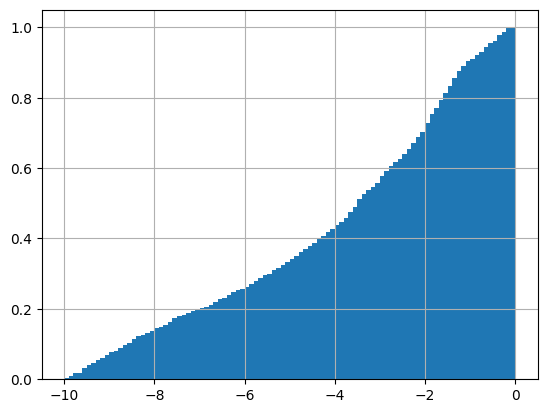

In [58]:
# llama7b_df["llama-7b_child_logprob"].hist(bins=100, range=(-10, 0), cumulative=True, density=False)

# now for 65b

llama65b_df["llama-65b_parent_logprob"].hist(bins=100, range=(-10, 0), cumulative=True, density=True)

<Axes: >

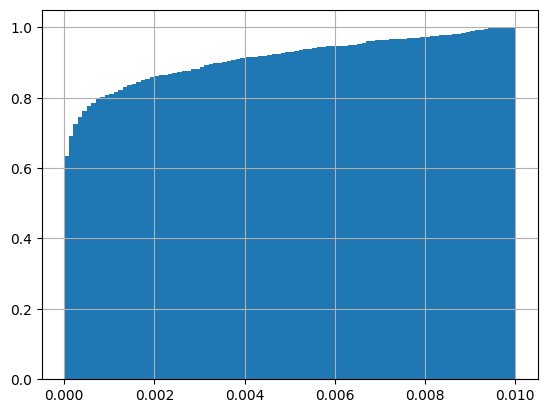

In [87]:
np.exp(llama65b_df["llama-65b_parent_logprob"]).hist(bins=100, range=(0, 0.01), cumulative=True, density=True)

<Axes: >

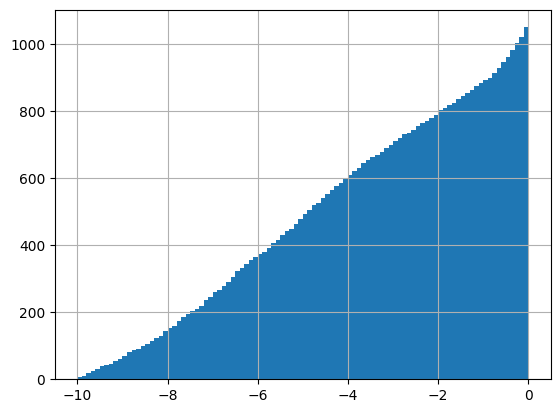

In [49]:
davinci_df["davinci_parent_logprob"].hist(bins=100, range=(-10, 0), cumulative=True, density=False)

In [ ]:
# Plot that shows how often gpt-4 can name the parent vs. name the child along with those same values for chatgpt, davinci, and llama-65b

